## Deep Learning-6, Programming exercise.
#### Done by :
#### Aysha Athar Siddiqui
#### Andrzej Reinke
#### Chan Chun Peng
#### Ramaswamy Venkatachalam
#### Yash Goel

In [66]:
import pickle
from pathlib import Path
from time import time
from collections import namedtuple
from itertools import repeat
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from torchsummary import summary

In [46]:
print('Device at work: ', device)

Device at work:  cuda:0


In [47]:
class TrainProgressBar:
    def __init__(self, num_runs, num_epochs, num_batches):
        self._runs_bar = tqdm(total=num_runs, desc="runs") if num_runs > 1 else None
        self._epoch_bar = tqdm(total=num_epochs, desc="epochs")
        self._batch_bar = tqdm(total=num_batches, desc="batches")
        
    @staticmethod
    def _decorate_iterator(it, pbar):
        try:
            pbar.reset(total=len(it))
        except TypeError:
            pbar.reset()
        
        for item in it:
            yield item
            pbar.update(1)
            
    def runs(self, iterator):
        if self._runs_bar:
            yield from TrainProgressBar._decorate_iterator(iterator, self._runs_bar)
        else:
            yield from iterator
        
    def epochs(self, iterator):
        yield from TrainProgressBar._decorate_iterator(iterator, self._epoch_bar)
        
    def batches(self, iterator):
        yield from TrainProgressBar._decorate_iterator(iterator, self._batch_bar)
        
    def write(self, text):
        self._batch_bar.write(text)
        
    def close(self):
        if self._runs_bar:
            self._runs_bar.close()
        self._epoch_bar.close()
        self._batch_bar.close()
        
    def __enter__(self):
        return self
    
    def __exit__(self, *exc):
        self.close()

In [108]:

class CIFAR10Dataset:
    def __init__(self, dataset='train', path='.', transform=None):
        path = Path(path)
        if dataset == 'train':
            batches = [self.load_batch(p) for p in path.glob('data_batch_*')]
            self.images = torch.cat([b for b, _ in batches])
            self.labels = torch.cat([b for _, b in batches])
        elif dataset == 'test':
            self.images, self.labels = self.load_batch(path / 'test_batch')
            
        # normalize
        self.images = self.images.float()
        self.labels = self.labels.long()
        
        std, mean = torch.std_mean(self.images, dim=0)
        self.images = (self.images - mean) / std
        
        self.transform = transform
        
        assert len(self.images) == len(self.labels)
    
    def load_batch(self, path):
        with open(path, 'rb') as file:
            data_dict = pickle.load(file, encoding='bytes')
        images = data_dict[b'data'].reshape((-1, 32, 32, 3), order='F').swapaxes(1,3)
        images = torch.from_numpy(images)
        labels = torch.Tensor(data_dict[b'labels'])
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        if(self.transform):
            print(x.shape)
            x = x.numpy().swapaxes(0,2)
            print(x.shape)
            x = Image.fromarray(x)
            x = self.transform(x)
        return x,y

In [68]:
class CUDADataLoader(DataLoader):
    def __iter__(self):
        for images, labels in super(CUDADataLoader, self).__iter__():
            yield [images.to(device), labels.to(device)]

In [69]:
PATH = "../dataset/cifar/cifar-10-batches-py/"

train_dataset = CIFAR10Dataset('train',PATH)
test_dataset = CIFAR10Dataset('test',PATH)

train_dataloader = CUDADataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = CUDADataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)


In [70]:
def predictions_to_hits(predictions, labels):
    return predictions.argmax(dim=1).eq(labels).count_nonzero()

def train(model, optimizer, train_dataloader, test_dataloader=None,
          loss_fn=None, reg_fn=None, num_epochs=25, pbar=None):
    
    # init outputs and progressbar
    
    losses = torch.zeros(num_epochs)
    train_accuracies = torch.zeros(num_epochs)
    test_accuracies = torch.zeros(num_epochs)
    
    for epoch in pbar.epochs(range(num_epochs)):
        
        # init variables
        
        epoch_losses = torch.zeros(len(train_dataloader)).to("cuda:0")
        hits = torch.zeros(1).to("cuda:0")
        total = torch.zeros(1).to("cuda:0")
        
        # train model
        
        model.train(True)
        
        for i, (images, labels) in enumerate(pbar.batches(train_dataloader)):
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            
            if(reg_fn):
                loss += reg_fn()
            
            loss.backward()
            optimizer.step()
            
            epoch_losses[i] = loss
            hits += predictions_to_hits(predictions, labels)
            total += len(images)
        
        losses[epoch] = torch.mean(epoch_losses)
        train_accuracies[epoch] = hits / total
        
        # get test accuracy
        
        model.train(False)
        
        if test_dataloader is not None:
            hits[:] = total[:] = 0
            for images, labels in pbar.batches(test_dataloader):
                predictions = model(images)
                hits += predictions_to_hits(predictions, labels)
                total += len(images)
            
        test_accuracies[epoch] = hits / total
        
        # update pbar
        
        pbar.write(f"[{epoch+1:>2}/{num_epochs}] "
                   f"train_accuracy: {train_accuracies[epoch]:.4f}, "
                   f"test_accuracy: {test_accuracies[epoch]:.4f}, "
                   f"loss: {losses[epoch]:.4f}")
    
    return tuple(a.detach().numpy() for a in (losses, train_accuracies, test_accuracies))

In [71]:
Results = namedtuple("Results", "losses train_accuracies test_accuracies")

def plot_results(names, results):
    _, axs = plt.subplots(1,2,figsize=(14,7))
    
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')
    
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('accuracy')
    
    for name, result in zip(names, results):
        a, *_ = axs[0].plot(result.losses, label=name)
        axs[1].plot(result.test_accuracies, label=name, color=a.get_color())
        #axs[1].plot(result.train_accuracies, label=name, color=a.get_color(), linestyle='dashed')

    axs[0].legend()
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [72]:
def make_bn_model():
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, 512),
        nn.BatchNorm1d(512,affine=False,momentum=0.1),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512,affine=False,momentum=0.1),
        nn.ReLU(),
        nn.Linear(512, 10),
        nn.BatchNorm1d(10,affine=False,momentum=0.1),
    ).to(device)

def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))

In [73]:
results = dict()

In [74]:
## batch norm model - Baseline Model
baseline = make_bn_model()
optimizer = make_optimizer(baseline)

with TrainProgressBar(1, 25, 782) as pbar:
    results["baseline"] = Results(*train(baseline, optimizer, train_dataloader, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.4287, test_accuracy: 0.4969, loss: 1.6355
[ 2/25] train_accuracy: 0.5091, test_accuracy: 0.5236, loss: 1.4525
[ 3/25] train_accuracy: 0.5482, test_accuracy: 0.5390, loss: 1.3704
[ 4/25] train_accuracy: 0.5778, test_accuracy: 0.5378, loss: 1.3061
[ 5/25] train_accuracy: 0.6072, test_accuracy: 0.5475, loss: 1.2512
[ 6/25] train_accuracy: 0.6320, test_accuracy: 0.5487, loss: 1.2037
[ 7/25] train_accuracy: 0.6528, test_accuracy: 0.5611, loss: 1.1609
[ 8/25] train_accuracy: 0.6747, test_accuracy: 0.5562, loss: 1.1178
[ 9/25] train_accuracy: 0.6925, test_accuracy: 0.5686, loss: 1.0821
[10/25] train_accuracy: 0.7135, test_accuracy: 0.5614, loss: 1.0449
[11/25] train_accuracy: 0.7311, test_accuracy: 0.5662, loss: 1.0125
[12/25] train_accuracy: 0.7503, test_accuracy: 0.5672, loss: 0.9792
[13/25] train_accuracy: 0.7694, test_accuracy: 0.5636, loss: 0.9471
[14/25] train_accuracy: 0.7812, test_accuracy: 0.5633, loss: 0.9228
[15/25] train_accuracy: 0.7990, test_accuracy: 0

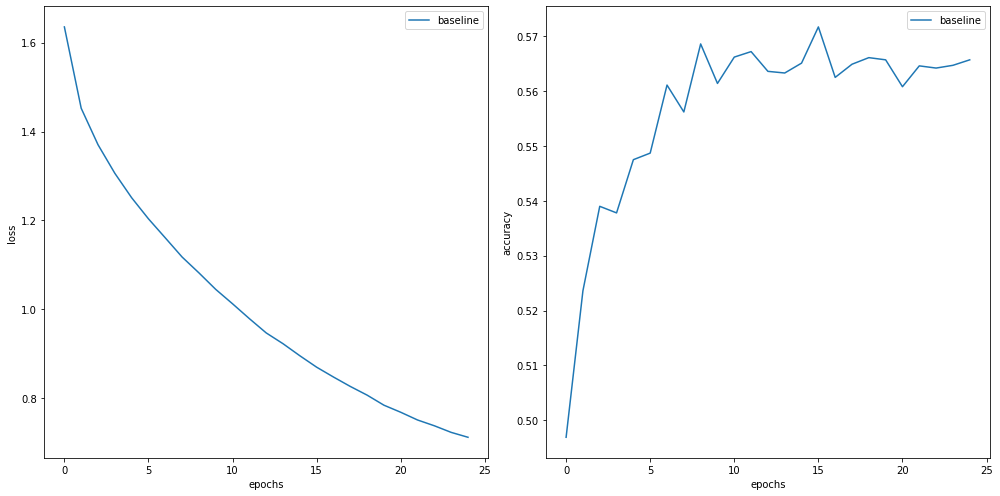

In [75]:
plot_results(['baseline'], [results['baseline']])


In [86]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3,padding=(1,1))        
        self.conv3 = nn.Conv2d(32, 64, 3,padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3,padding=(1,1))
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1,4096)
        return self.flatten(x)

In [87]:
summary(CNNModel().cuda(),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 32, 32]           9,248
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                   [-1, 10]          40,970
Total params: 106,538
Trainable params: 106,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.41
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


In [88]:
## cnn model
cnn_model = CNNModel().cuda()
optimizer = make_optimizer(cnn_model)

with TrainProgressBar(1, 25, 782) as pbar:
    results["cnn_model"] = Results(*train(cnn_model, optimizer, train_dataloader, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.4829, test_accuracy: 0.5805, loss: 1.4421
[ 2/25] train_accuracy: 0.6344, test_accuracy: 0.6672, loss: 1.0484
[ 3/25] train_accuracy: 0.6945, test_accuracy: 0.7015, loss: 0.8773
[ 4/25] train_accuracy: 0.7332, test_accuracy: 0.7188, loss: 0.7657
[ 5/25] train_accuracy: 0.7629, test_accuracy: 0.7316, loss: 0.6835
[ 6/25] train_accuracy: 0.7871, test_accuracy: 0.7390, loss: 0.6142
[ 7/25] train_accuracy: 0.8083, test_accuracy: 0.7418, loss: 0.5566
[ 8/25] train_accuracy: 0.8248, test_accuracy: 0.7628, loss: 0.5038
[ 9/25] train_accuracy: 0.8423, test_accuracy: 0.7584, loss: 0.4549
[10/25] train_accuracy: 0.8563, test_accuracy: 0.7616, loss: 0.4132
[11/25] train_accuracy: 0.8684, test_accuracy: 0.7576, loss: 0.3771
[12/25] train_accuracy: 0.8824, test_accuracy: 0.7529, loss: 0.3376
[13/25] train_accuracy: 0.8921, test_accuracy: 0.7585, loss: 0.3084
[14/25] train_accuracy: 0.9025, test_accuracy: 0.7543, loss: 0.2773
[15/25] train_accuracy: 0.9129, test_accuracy: 0

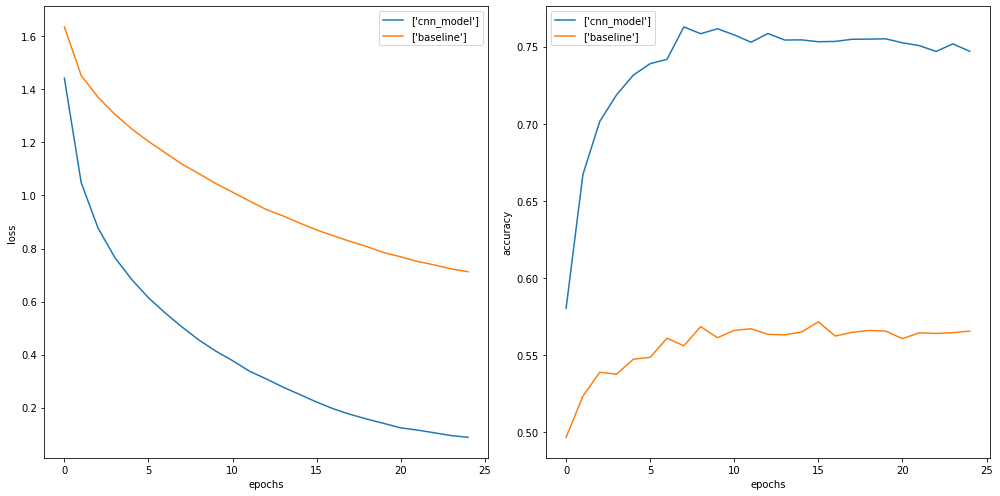

In [89]:
plot_results([['cnn_model'],['baseline']], [results['cnn_model'],results['baseline']])

In [109]:
### define transformations
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset_transform = CIFAR10Dataset('train',PATH,transform=transform_train)
train_dataloader_transform = CUDADataLoader(train_dataset_transform, batch_size=64, shuffle=True, pin_memory=True)

In [110]:
## cnn model with tranformations
cnn_model_trans = CNNModel().cuda()
optimizer = make_optimizer(cnn_model_trans)

with TrainProgressBar(1, 25, 782) as pbar:
    results["cnn_model_trans"] = Results(*train(cnn_model_trans, optimizer, train_dataloader_transform, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

torch.Size([3, 32, 32])
(32, 32, 3)




TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>

In [69]:
plot_results([['cnn_model'],['cnn_model_trans'],['baseline']], 
             [results['cnn_model'],results['cnn_model_trans'],results['baseline']])

KeyError: 'cnn_model_trans'

In [ ]:
# TODO: ADD REGULARISATION
class CNNModelReg(nn.Module):
    def __init__(self):
        super(CNNModelReg, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3,padding=(1,1))        
        self.conv3 = nn.Conv2d(32, 64, 3,padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3,padding=(1,1))
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        print(x.shape)
        x = x.view(-1,4096)
        return self.flatten(x)

In [ ]:
## cnn model with tranformations
cnn_model_trans_reg = CNNModelReg().cuda()
optimizer = make_optimizer(cnn_model_trans_reg)

with TrainProgressBar(1, 25, 782) as pbar:
    results["cnn_model_trans_reg"] = Results(*train(cnn_model_trans_reg, optimizer, train_dataloader_transform, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

# Visualizing filter respones

In [140]:
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().reshape(3,32,32).transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

torch.Size([1, 3, 32, 32])


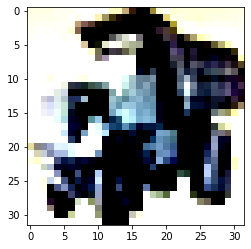

In [141]:
vis_dataloader = CUDADataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
img, label = next(iter(vis_dataloader))
print(img.shape)
imshow(img)

In [154]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def plot_activation(act_,rows=8,cols=4):
    act = act_.squeeze().cpu()
    fig=plt.figure(figsize=(10, 10))
    for i in range(1, cols*rows +1):
        img = act[i-1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
    plt.show()

In [155]:
cnn_model.conv1.register_forward_hook(get_activation('conv1'))
cnn_model.conv2.register_forward_hook(get_activation('conv2'))
cnn_model.conv3.register_forward_hook(get_activation('conv3'))
cnn_model.conv4.register_forward_hook(get_activation('conv4'))

output = cnn_model(img)

torch.Size([1, 32, 32, 32])


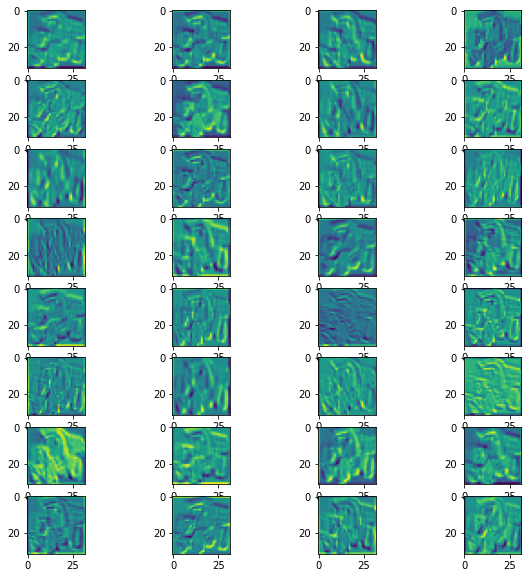

In [159]:
plot_activation(activation['conv1'])

torch.Size([1, 32, 32, 32])


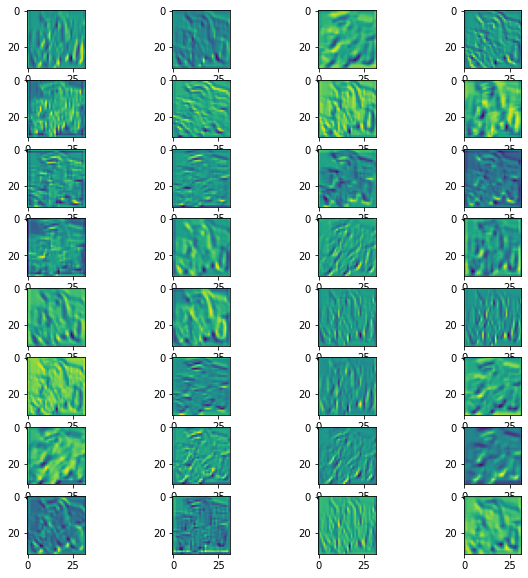

In [161]:
plot_activation(activation['conv2'])

torch.Size([1, 64, 16, 16])


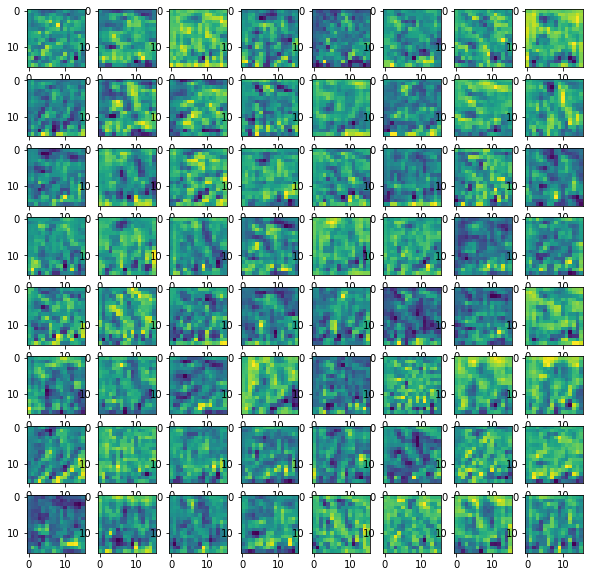

In [163]:
plot_activation(activation['conv3'],cols=8)

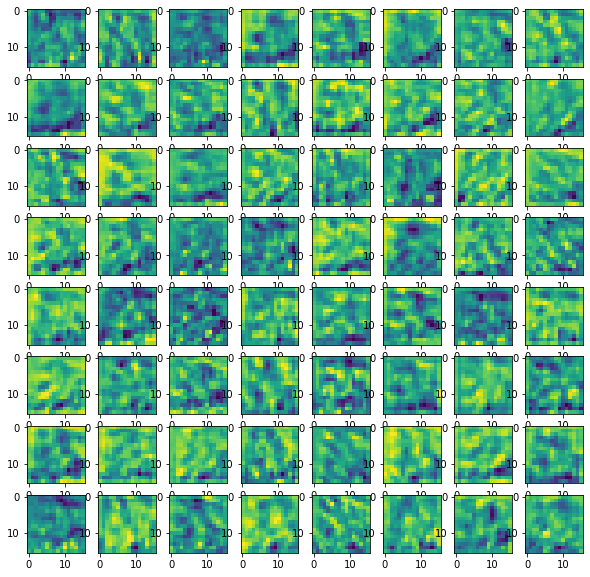

In [164]:
plot_activation(activation['conv4'],cols=8)